Virus Sequence Clustering Analysis using K-means

This script performs clustering analysis on virus sequence alignment data using K-means
clustering and dimensionality reduction techniques. It includes data preprocessing,
exploratory data analysis, clustering, and visualization of results.

The analysis pipeline includes:
1. Data loading and preprocessing
2. Exploratory data analysis with visualizations
3. Dimensionality reduction using PCA
4. K-means clustering with elbow method optimization
5. t-SNE visualization of clustering results

`Author: Pouryare`

`Date: 2024-10-25`

In [1]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [2]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('jamzing/sars-coronavirus-accession', path="/content/drive/MyDrive/ML/coronavirus-accession", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/jamzing/sars-coronavirus-accession


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Optional
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [21]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [22]:
def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """
    Load and preprocess the virus sequence alignment data.

    Args:
        file_path (str): Path to the CSV file containing alignment data

    Returns:
        pd.DataFrame: Preprocessed DataFrame with renamed columns and encoded categorical variables

    Global purpose:
        This function establishes the foundation for our analysis by preparing
        the raw data into a format suitable for machine learning algorithms.
    """
    # Read the CSV file
    data = pd.read_csv(file_path)

    # Rename columns for clarity
    column_mapping = {
        "MN997409.1": "query_acc_ver",
        "MN997409.1.1": "subject_acc_ver",
        "100.000": "identity_percentage",
        "29882": "alignment_length",
        "0": "mismatches",
        "0.1": "gap_opens",
        "1": "q_start",
        "29882.1": "q_end",
        "1.1": "s_start",
        "29882.2": "s_end",
        "0.0": "evalue",
        "55182": "bit_score"
    }
    data = data.rename(columns=column_mapping)

    # Convert subject accession version to categorical codes
    # Local purpose: Enable numerical processing of categorical data
    data['subject_acc_ver'] = data['subject_acc_ver'].astype("category").cat.codes

    return data

In [23]:
def visualize_data_distribution(data: pd.DataFrame) -> None:
    """
    Create visualizations for understanding data distribution.

    Args:
        data (pd.DataFrame): Preprocessed DataFrame

    Global purpose:
        Provide insights into data characteristics and potential patterns
        before applying clustering algorithms.
    """
    plt.figure(figsize=(15, 10))

    # Plot 1: Identity percentage distribution
    plt.subplot(2, 2, 1)
    sns.histplot(data['identity_percentage'], bins=30)
    plt.title('Distribution of Identity Percentage')
    plt.xlabel('Identity Percentage')

    # Plot 2: Alignment length vs Bit score
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=data, x='alignment_length', y='bit_score')
    plt.title('Alignment Length vs Bit Score')

    # Plot 3: Mismatches vs Gap opens
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=data, x='mismatches', y='gap_opens')
    plt.title('Mismatches vs Gap Opens')

    # Plot 4: Query position distribution
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=data, x='q_start', y='q_end')
    plt.title('Query Start vs End Positions')

    plt.tight_layout()
    plt.show()

In [24]:
def reduce_dimensions(X: np.ndarray, n_components: float = 0.95) -> Tuple[np.ndarray, PCA]:
    """
    Reduce data dimensions using PCA.

    Args:
        X (np.ndarray): Input feature matrix
        n_components (float): Desired explained variance ratio

    Returns:
        Tuple[np.ndarray, PCA]: Reduced data and fitted PCA object

    Global purpose:
        Reduce computational complexity while preserving important patterns in the data.
        This is crucial for efficient clustering and visualization.
    """
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    X_reduced = pca.fit_transform(X)

    # Visualize explained variance
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('PCA Explained Variance Ratio')
    plt.show()

    return X_reduced, pca

In [25]:
def find_optimal_clusters(X: np.ndarray, max_k: int = 20) -> None:
    """
    Determine optimal number of clusters using elbow method.

    Args:
        X (np.ndarray): Input data matrix
        max_k (int): Maximum number of clusters to test

    Global purpose:
        Find the best number of clusters to balance between
        model complexity and clustering quality.
    """
    distortions = []
    K = range(2, max_k)

    # Calculate distortion for different k values
    for k in tqdm(K):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
        kmeans.fit(X)
        distortions.append(
            sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
        )

    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K, distortions, 'b-')
    plt.plot([K[0], K[-1]], [distortions[0], distortions[-1]], 'r--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Distortion')
    plt.title('Elbow Method for Optimal k')
    plt.show()

In [26]:
def perform_clustering(X: np.ndarray, n_clusters: int) -> np.ndarray:
    """
    Perform K-means clustering on the data.

    Args:
        X (np.ndarray): Input data matrix
        n_clusters (int): Number of clusters

    Returns:
        np.ndarray: Cluster labels for each data point

    Global purpose:
        Group similar virus sequences together to identify potential patterns
        and relationships in the data.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
    return kmeans.fit_predict(X)

In [27]:
def visualize_clusters_tsne(X: np.ndarray, labels: np.ndarray, perplexity: int = 200) -> None:
    """
    Visualize clustering results using t-SNE.

    Args:
        X (np.ndarray): Input data matrix
        labels (np.ndarray): Cluster labels
        perplexity (int): t-SNE perplexity parameter

    Global purpose:
        Create interpretable visualization of high-dimensional clustering results
        to help understand the relationships between different virus sequences.
    """
    # Scale features before t-SNE
    from sklearn.preprocessing import StandardScaler
    X_scaled = StandardScaler().fit_transform(X)

    # Perform t-SNE with specific parameters to match original
    tsne = TSNE(
        verbose=1,
        init='pca',
        perplexity=perplexity,
        random_state=RANDOM_SEED,
        learning_rate=200.0,  # Match original default
        n_iter=1000,  # Match original iterations
        metric='euclidean'
    )
    X_embedded = tsne.fit_transform(X_scaled)

    # Plot results with seaborn styling to match original
    plt.figure(figsize=(10, 10))
    sns.set_style("darkgrid")
    palette = sns.hls_palette(len(np.unique(labels)), l=.4, s=.9)

    # Create scatter plot with larger points and alpha
    sns.scatterplot(
        x=X_embedded[:, 0],
        y=X_embedded[:, 1],
        hue=labels,
        legend='full',
        palette=palette,
        s=100,  # Larger point size
        alpha=0.7  # Some transparency
    )
    plt.title('t-SNE with Kmeans Labels')
    plt.show()

In [28]:
file_path = '/content/drive/MyDrive/ML/coronavirus-accession/MN997409.1-4NY0T82X016-Alignment-HitTable.csv'

In [29]:
# Load and preprocess data
data = load_and_preprocess_data(file_path)
print("Data shape:", data.shape)
print("\nFirst few rows of preprocessed data:")
data.head()

Data shape: (262, 12)

First few rows of preprocessed data:


,query_acc_ver,subject_acc_ver,identity_percentage,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bit_score
0,MN997409.1,85,99.990,29882,3,0,1,29882,1,29882,0.0,55166
1,MN997409.1,84,99.990,29882,3,0,1,29882,1,29882,0.0,55166
2,MN997409.1,66,99.990,29882,3,0,1,29882,1,29882,0.0,55166
3,MN997409.1,65,99.990,29882,3,0,1,29882,1,29882,0.0,55166
4,MN997409.1,55,99.993,29878,2,0,4,29881,1,29878,0.0,55164


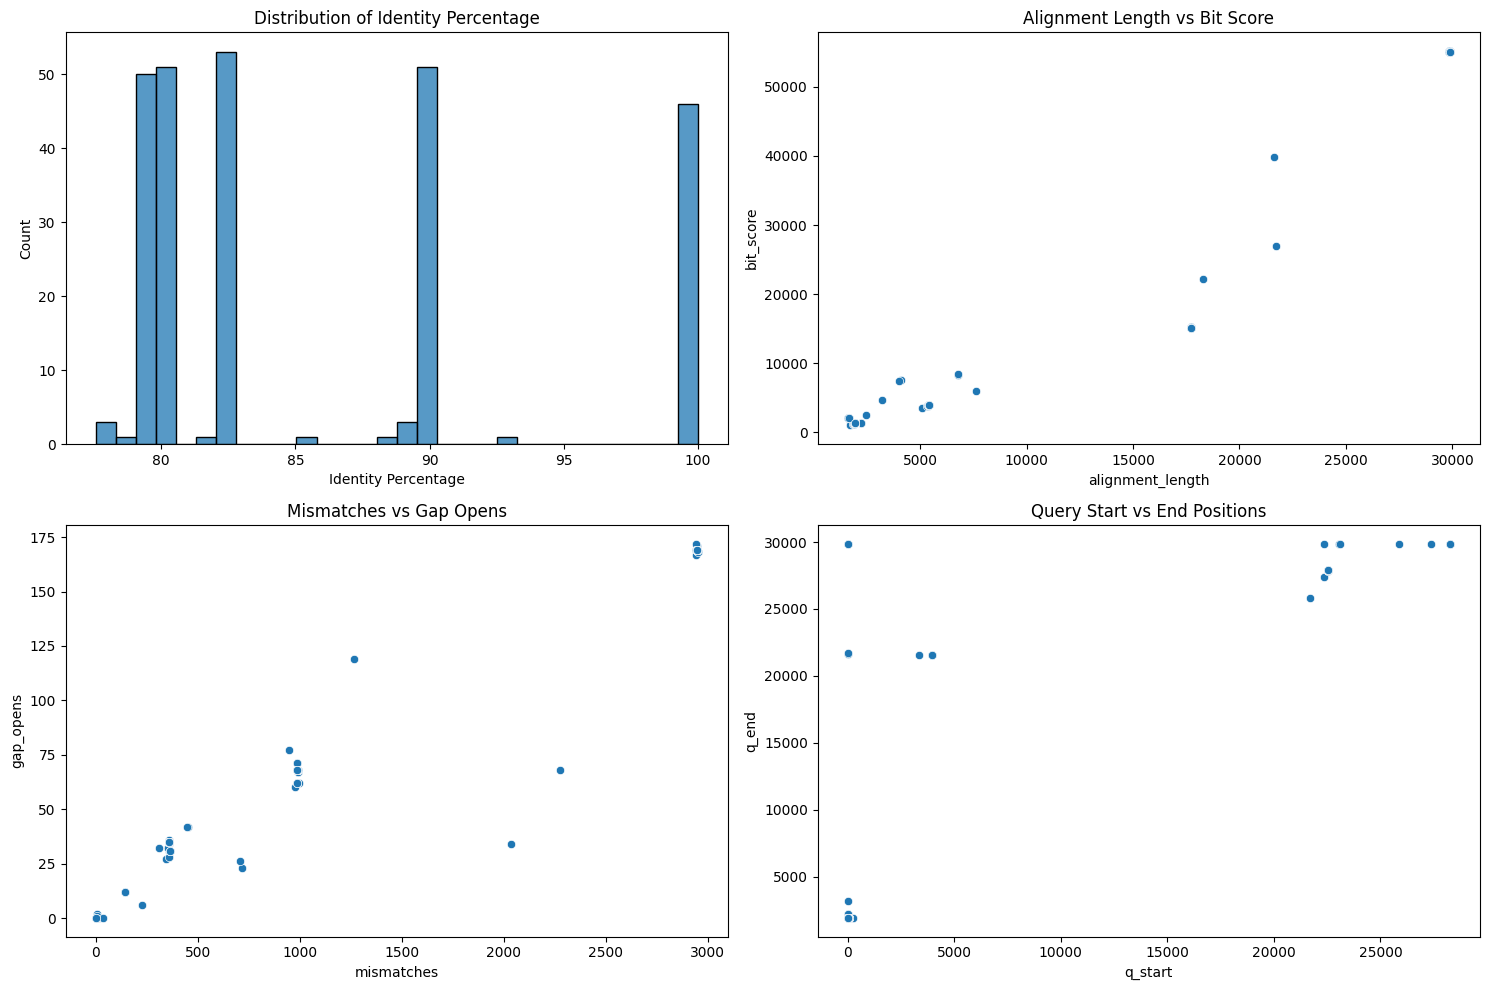

In [30]:
# Visualize data distributions
visualize_data_distribution(data)

In [31]:
# Prepare feature matrix
X = data.iloc[:, 1:].values  # Exclude query accession version

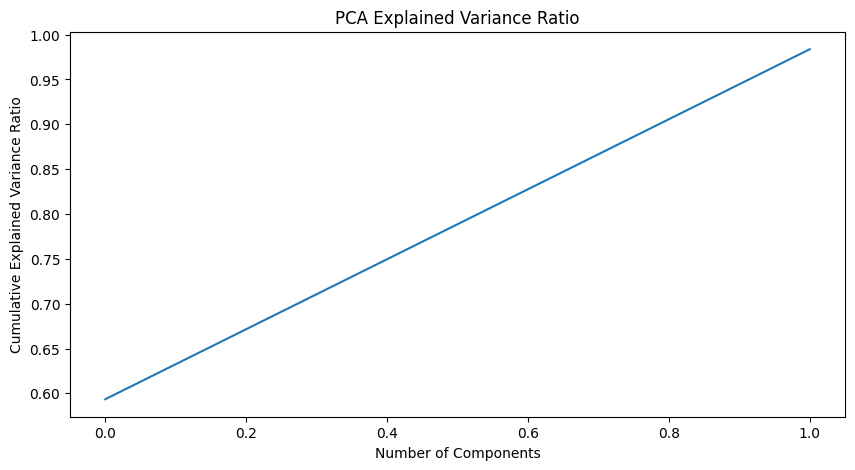


Reduced data shape: (262, 2)


In [32]:
# Reduce dimensions
X_reduced, pca = reduce_dimensions(X)
print("\nReduced data shape:", X_reduced.shape)

100%|██████████| 18/18 [00:00<00:00, 324.79it/s]


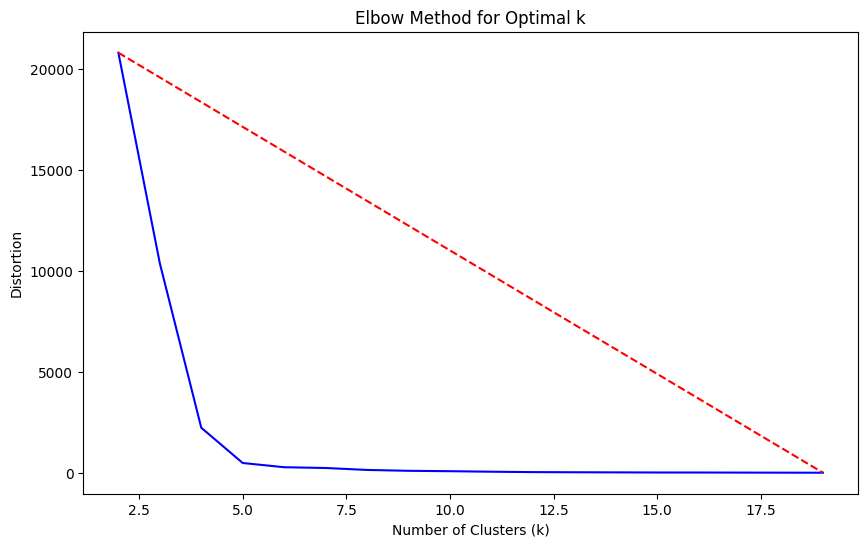

In [33]:
# Find optimal number of clusters
find_optimal_clusters(X_reduced)

In [34]:
# Perform clustering with optimal k=5 (based on elbow plot)
n_clusters = 5
labels = perform_clustering(X_reduced, n_clusters)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 261 nearest neighbors...
[t-SNE] Indexed 262 samples in 0.000s...
[t-SNE] Computed neighbors for 262 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 262 / 262
[t-SNE] Mean sigma: 3.988260
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.103188
[t-SNE] KL divergence after 800 iterations: 0.008294


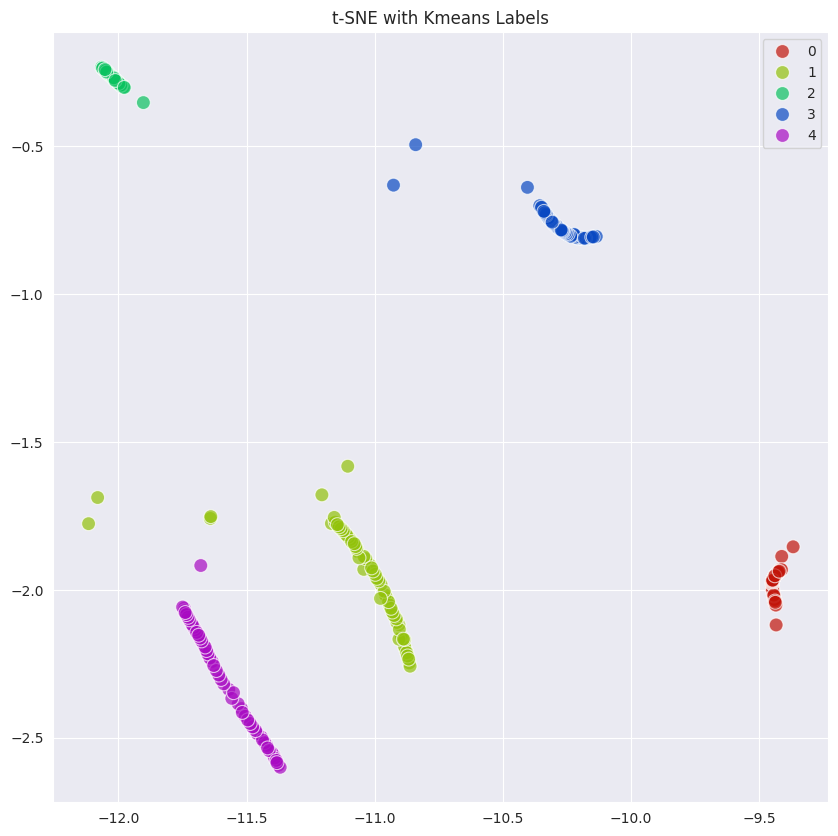

In [35]:
# Visualize results
visualize_clusters_tsne(X, labels)

In [36]:
# Add cluster labels to DataFrame
data['cluster'] = labels
print("\nSample of data with cluster labels:")
print(data[['query_acc_ver', 'subject_acc_ver', 'identity_percentage', 'cluster']].head())


Sample of data with cluster labels:
  query_acc_ver  subject_acc_ver  identity_percentage  cluster
0    MN997409.1               85               99.990        2
1    MN997409.1               84               99.990        2
2    MN997409.1               66               99.990        2
3    MN997409.1               65               99.990        2
4    MN997409.1               55               99.993        2
